<a id=top-page></a>
# Testing the perplexity parameter setting in t-SNE

In this notebook, we test setting the perplexity parameter to a value dependent on the total number of observations in a dataset. We use the MNIST categorical dataset.

The analysis in this notebook is performed in the following steps:

- [Load the MNIST data](#load-data)
- [Run the cost function assessments of various perplexity settings](#perplexity-setting)
- [Plotting the costs](#plotting)

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
bandwidth_values = np.logspace(-7, 3, 200)
penalty = 'log-sigma-over-peak'
norm = 'max'
power = 1
vertical_shift = 1

In [3]:
perplexity_thresholds = np.array([1/1000, 1/500, 1/250, 1/200, 1/150, 1/125, 1/100, 1/90, 1/80, 1/70])
perplexity_thresholds_labels = ['$n/1000$','$n/500$','$n/250$','$n/200$', '$n/150$', '$n/125$', '$n/100$', '$n/90$', '$n/80$', '$n/70$']

<a id=load-data></a>
***

## Load the MNIST data

[Go to the top](#top-page)

In [4]:
mnist = fetch_openml("mnist_784", version=1)
color = mnist.target.astype(int)

In [7]:
(n_observations, n_variables) = np.shape(mnist.data)

<a id=perplexity-setting></a>
***

## Run the cost function assessments of various perplexity settings

[Go to the top](#top-page)

In [8]:
n_samples_list = [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000]

In [9]:
n_obs_labels = ['5,000', '10,000', '15,000', '20,000', '30,000', '40,000', '50,000', '60,000']

In [10]:
for n_samples in n_samples_list:
    
    print('Running for: ' + str(n_samples))

    manual_samples = {}
    for i in range(0,len(np.unique(color))):
        manual_samples[i] = n_samples
        
    sample_random = preprocess.DataSampler(color, random_seed=random_seed, verbose=False)
    (idx_sample, _) = sample_random.manual(sampling_dictionary=manual_samples, sampling_type='number')
    X = mnist.data[idx_sample,:]
    idx = color[idx_sample]

    (n_observations, n_dimensions) = np.shape(X)
    depvar = idx[:,None]
    
    perplexity_values = (n_observations*perplexity_thresholds).astype(int)
    
    costs = []

    for perplexity in perplexity_values:

        tic = time.perf_counter()

        print('Perplexity: ' + str(perplexity))

        X_TSNE = manifold.TSNE(n_components=2, perplexity=perplexity, init="pca", random_state=random_seed).fit_transform(X)

        variance_data = analysis.compute_normalized_variance(X_TSNE,
                                                             depvar,
                                                             depvar_names=['var'],
                                                             bandwidth_values=bandwidth_values)

        cost = analysis.cost_function_normalized_variance_derivative(variance_data,
                                                                     penalty_function=penalty,
                                                                     power=power,
                                                                     vertical_shift=vertical_shift,
                                                                     norm=norm,
                                                                     integrate_to_peak=False)

        print(cost)

        costs.append(cost)

        toc = time.perf_counter()
        print(f'\tTime it took: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

    np.savetxt('perplexity-tuning-t-SNE-none-scaling-2D-LDM-costs-MNIST-' + str(n_samples) + '-samples.csv', (costs), delimiter=',', fmt='%.16e')

<a id=plotting></a>
***

## Plotting the costs

[Go to the top](#top-page)

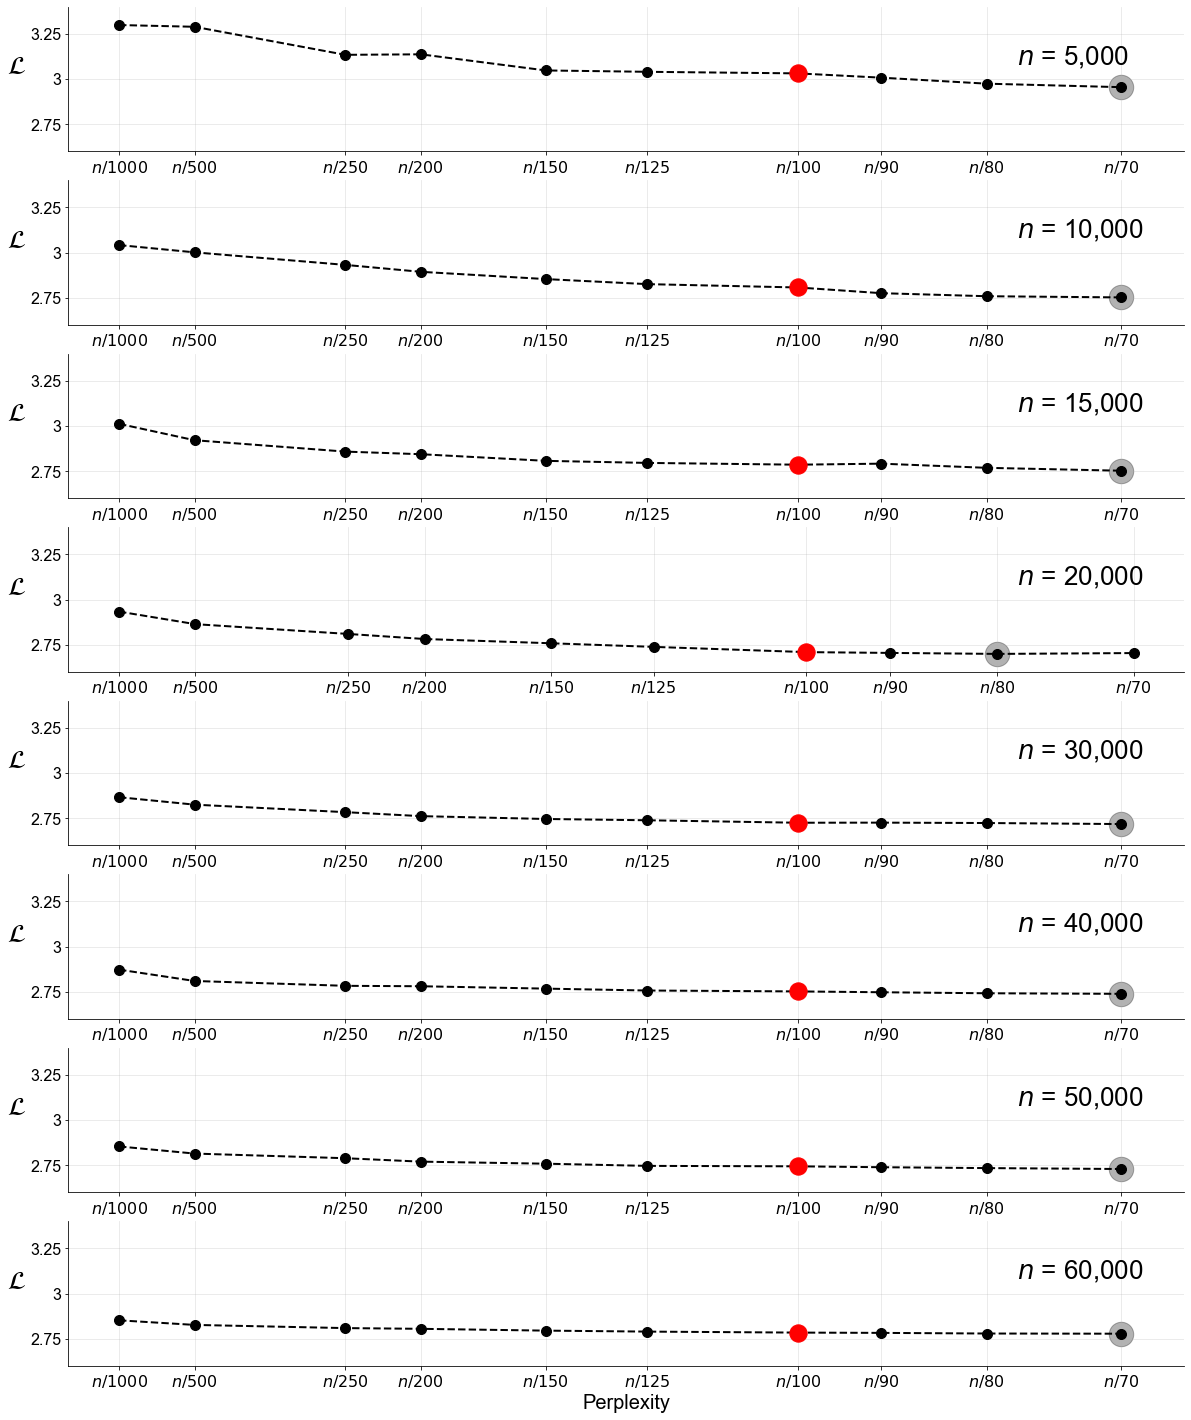

In [11]:
fig = plt.figure(figsize=(20, 25))
spec = fig.add_gridspec(ncols=1, nrows=len(n_samples_list), width_ratios=[1], height_ratios=[1 for i in range(0,len(n_samples_list))])

for i, n_samples in enumerate(n_samples_list):
    
    perplexity_values = (n_observations*perplexity_thresholds).astype(int)
    
    costs = pd.read_csv('../results/perplexity-tuning-t-SNE-none-scaling-2D-LDM-costs-MNIST-' + str(n_samples) + '-samples.csv', header=None).to_numpy()
    
    (idx_min, _) = np.where(costs==np.min(costs))
    idx_min = int(idx_min)
    
    ax = fig.add_subplot(spec[i,0])
    ax.plot(perplexity_values, costs, 'o--', c='k', lw=2, markersize=10)
    ax.scatter(perplexity_values[-4], costs[-4], c='r', s=300, zorder=100)
    ax.scatter(perplexity_values[idx_min], costs[idx_min], marker='o', c='k', s=600, zorder=0, alpha=0.3)
    ax.set_yticks([2.75,3,3.25])
    ax.set_yticklabels([2.75,3,3.25], fontsize=16)
    plt.ylim([2.6, 3.4])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel('$\mathcal{L}$', fontsize=26, rotation=0, horizontalalignment='right')
    plt.grid(alpha=0.3)
    ax.set_xticks(perplexity_values)
    ax.set_xticklabels(perplexity_thresholds_labels, fontsize=16)
    plt.text(0.85,0.6, '$n$ = ' + str(n_obs_labels[i]), fontsize=26, transform=ax.transAxes)
    
plt.xlabel('Perplexity', fontsize=20)
plt.savefig('../figures/t-SNE-n-dependent-perplexity.pdf', dpi=300, bbox_inches='tight')

***